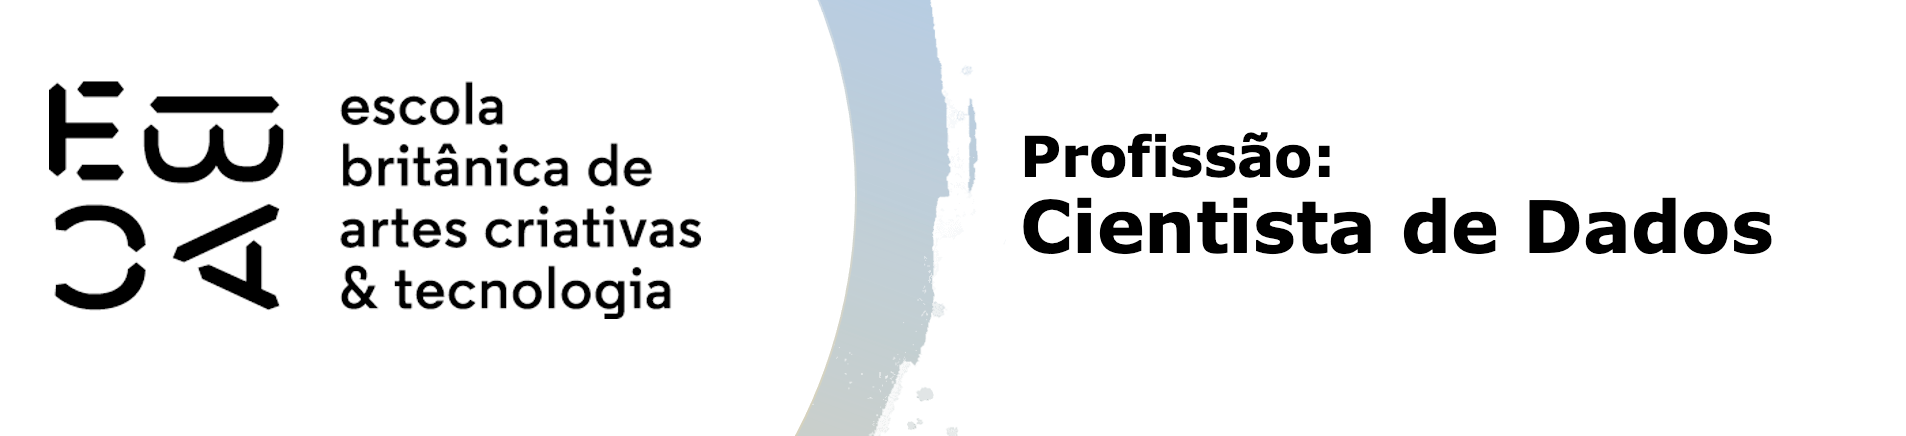

# Regressão III - Tarefa

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.interpolate import interp1d
import warnings

# Ignorar todos os warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv("C:/Users/rodri/previsao_de_renda_II.csv", index_col=0)
df.head()


,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [8]:
df.isna().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [9]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())

In [10]:
df.isna().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [11]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [14]:
cutoff_date = df.index[-1] - pd.DateOffset(months=3) #fazemos isso para determinar a data de corte do df

In [15]:
df_train = df[df.index < cutoff_date]
df_test = df[df.index >= cutoff_date]

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [16]:
df_train.reset_index(inplace=True)

In [17]:
df_train.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda'],
      dtype='object')

In [18]:
y_train = df_train['renda']
X_train = df_train.drop(columns=['renda', df_train.columns[0]])
X_train = pd.get_dummies(X_train, drop_first=True)
X_train = X_train.astype(int)

In [19]:
model = sm.OLS(np.log(y_train), X_train).fit()
print(f'R-quadrado: {model.rsquared:.2%}')
print(model.summary())

R-quadrado: 99.03%
                                 OLS Regression Results                                
Dep. Variable:                  renda   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          2.256e+06
Date:                Fri, 24 Jan 2025   Prob (F-statistic):                        0.00
Time:                        11:21:33   Log-Likelihood:                     -7.3791e+05
No. Observations:              550000   AIC:                                  1.476e+06
Df Residuals:                  549975   BIC:                                  1.476e+06
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
---

### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [22]:
df_train.loc[:, 'log_renda'] = np.log(df_train['renda'])

# Categorizar tempo_emprego em 20 quantis apenas no treino
df_train.loc[:, 'tempo_emprego_cat'] = pd.qcut(df_train['tempo_emprego'], q=20, duplicates='drop', labels=False)

# Tabela de perfil para a categorização
profile_table = df_train.groupby('tempo_emprego_cat').agg({
    'tempo_emprego': 'mean',
    'log_renda': 'mean',
    'tempo_emprego_cat': 'size'  # Contagem de observações
})

profile_table.columns = ['media_tempo_emprego', 'media_log_renda', 'observacoes']

# Exibir a tabela de perfil
print("Tabela de Perfil:")
profile_table

Tabela de Perfil:


,media_tempo_emprego,media_log_renda,observacoes
tempo_emprego_cat,,,
0,0.514613,8.424778,27725
1,1.124968,8.515460,27543
2,1.781155,8.629500,27315
3,2.511579,8.685328,27448
4,3.301011,8.817479,27854
5,3.989400,8.913815,27296
6,4.612497,8.968877,27444
7,5.367651,9.110178,27493
8,6.206258,9.201152,27474


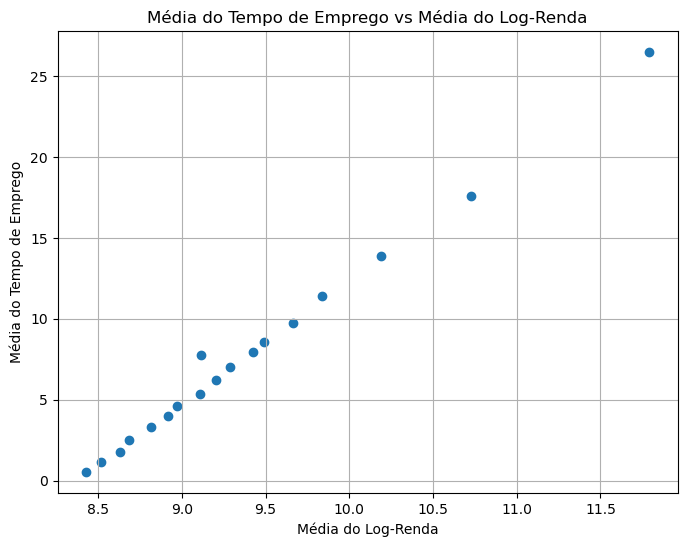

In [24]:
# Gráfico de dispersão: média do tempo de emprego versus média do log-renda
plt.figure(figsize=(8, 6))
plt.scatter(profile_table['media_log_renda'], profile_table['media_tempo_emprego'])
plt.title('Média do Tempo de Emprego vs Média do Log-Renda')
plt.xlabel('Média do Log-Renda')
plt.ylabel('Média do Tempo de Emprego')
plt.grid(True)
plt.show()

R-quadrado: 99.34%


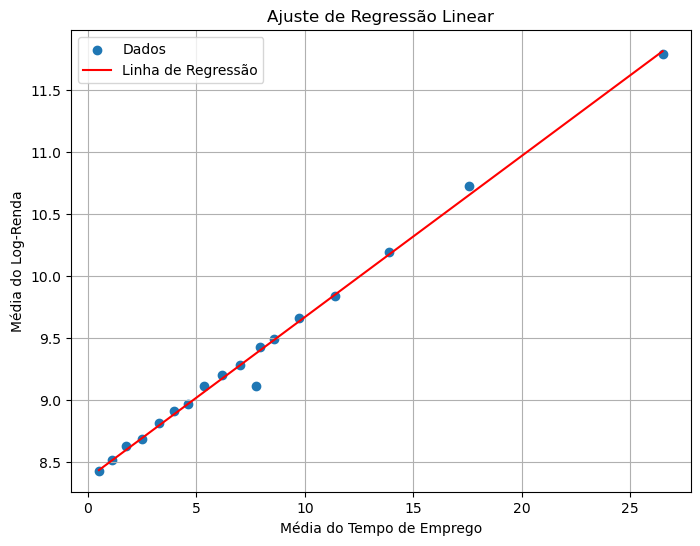

In [25]:
# Ajuste de Regressão Linear
formula = 'media_log_renda ~ media_tempo_emprego' 

res2 = smf.ols(formula ,data=profile_table).fit()
X = profile_table['media_tempo_emprego']
y_pred = res2.predict(profile_table[['media_tempo_emprego']])
print(f'R-quadrado: {res2.rsquared:.2%}')

# Plotando a linha de regressão sobre os dados
plt.figure(figsize=(8, 6))
plt.scatter(profile_table['media_tempo_emprego'], profile_table['media_log_renda'], label='Dados')
plt.plot(X, y_pred, color='red', label='Linha de Regressão')
plt.title('Ajuste de Regressão Linear')
plt.xlabel('Média do Tempo de Emprego')
plt.ylabel('Média do Log-Renda')
plt.legend()
plt.grid(True)
plt.show()

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


### 1 vamos testar aplicar o log também no X e ver se o ajuste melhora:

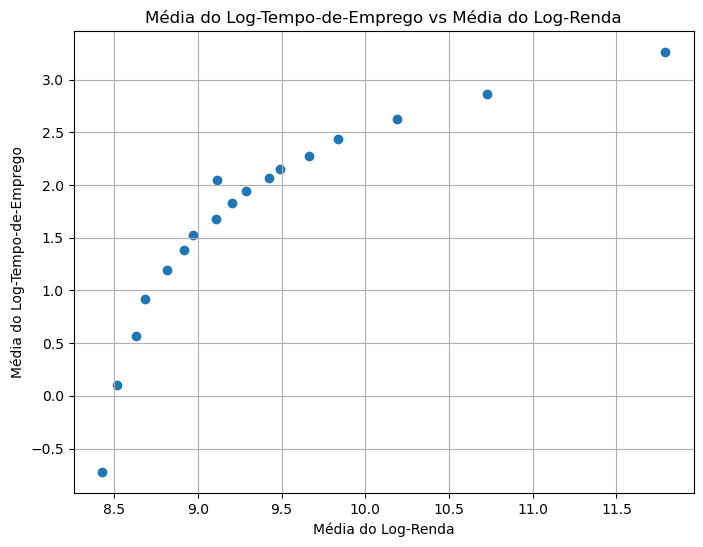

In [26]:
df_train['log_renda'] = np.log(df_train['renda'])
df_train['log_tempo_emprego'] = np.log(df_train['tempo_emprego'])

df_train['log_tempo_emprego_cat'] = pd.qcut(df_train['log_tempo_emprego'], q=20, duplicates='drop', labels=False)

profile_table_yx = df_train.groupby(['log_tempo_emprego_cat']).agg({
    'log_renda': 'mean',
    'log_tempo_emprego': 'mean',
    'log_tempo_emprego_cat': 'size'  # Contagem de observações
})

profile_table_yx.columns = ['media_log_renda', 'media_log_tempo_emprego', 'observacoes']

# Gráfico
plt.figure(figsize=(8, 6))
plt.scatter(profile_table_yx['media_log_renda'], profile_table_yx['media_log_tempo_emprego'])
plt.title('Média do Log-Tempo-de-Emprego vs Média do Log-Renda')
plt.xlabel('Média do Log-Renda')
plt.ylabel('Média do Log-Tempo-de-Emprego')
plt.grid(True)
plt.show()

R-quadrado: 71.80%


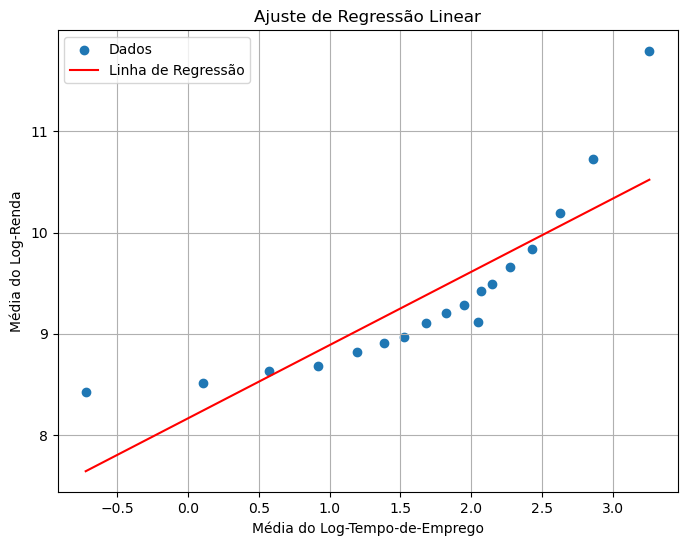

In [27]:
# Ajuste de Regressão Linear
formula2 = 'media_log_renda ~ media_log_tempo_emprego' 

res3 = smf.ols(formula2 ,data=profile_table_yx).fit()
X = profile_table_yx['media_log_tempo_emprego']
y_pred = res3.predict(profile_table_yx[['media_log_tempo_emprego']])
print(f'R-quadrado: {res3.rsquared:.2%}')

# Plotando a linha de regressão sobre os dados
plt.figure(figsize=(8, 6))
plt.scatter(profile_table_yx['media_log_tempo_emprego'], profile_table_yx['media_log_renda'], label='Dados')
plt.plot(X, y_pred, color='red', label='Linha de Regressão')
plt.title('Ajuste de Regressão Linear')
plt.xlabel('Média do Log-Tempo-de-Emprego')
plt.ylabel('Média do Log-Renda')
plt.legend()
plt.grid(True)
plt.show()

#### Aplicando log tanto no X como no Y trouxe um ajuste piorado, como indicado visualmente e pelo valor de R² acima.

### 2 Agora vamos testar a técnica de suavização Lowess:

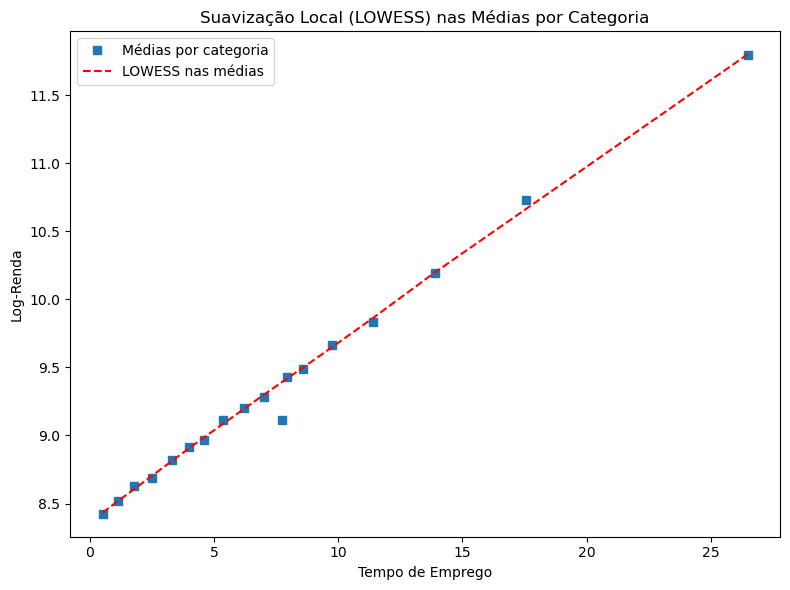

In [28]:
# Aplicar LOWESS nas médias
lowess = sm.nonparametric.lowess(profile_table['media_log_renda'], profile_table['media_tempo_emprego'], frac=2/3)
lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]

# Plotagem
fig, ax = plt.subplots(figsize=(8, 6))

# Plotar as médias de cada categoria
ax.plot(profile_table['media_tempo_emprego'], profile_table['media_log_renda'], "s", label="Médias por categoria")

# Plotar a linha LOWESS
ax.plot(lowess_x, lowess_y, "r--", label="LOWESS nas médias")

ax.set_xlabel("Tempo de Emprego")
ax.set_ylabel("Log-Renda")
ax.set_title("Suavização Local (LOWESS) nas Médias por Categoria")

ax.legend()
plt.tight_layout()
plt.show()

In [29]:
f = interp1d(lowess_x, lowess_y, bounds_error=False)

profile_table['X_lowess'] = f(profile_table.media_tempo_emprego)

res4 = smf.ols('media_log_renda ~ X_lowess',data=profile_table).fit()

print(f'R-quadrado: {res4.rsquared:.2%}')
res4.summary()

R-quadrado: 99.33%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        media_log_renda   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2371.
Date:                Fri, 24 Jan 2025   Prob (F-statistic):           8.02e-19
Time:                        11:27:08   Log-Likelihood:                 23.020
No. Observations:                  18   AIC:                            -42.04
Df Residuals:                      16   BIC:                            -40.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0427      0.194     -0.220      0.829      -0.454       0.369
X_lowess       1.0032      0.021     48.697      0.000       0.960       1.047
==============================================================================
Omnibus:                       40.788   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.899
Skew:                          -3.325   Prob(JB):                     4.13e-26
Kurtosis:                      13.566   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [30]:
r2 = [0.9903, 0.9934, 0.7180, 0.9933]
modelos = ['Regressão Simples', 'Categorização com Log em Y', 'Categorização com Log em X e Y', 'Categorização com Lowess']

resultados = pd.DataFrame({
    'Modelos': modelos,
    'R²': r2
})

# Exibir a tabela de resultados
resultados

,Modelos,R²
0,Regressão Simples,0.9903
1,Categorização com Log em Y,0.9934
2,Categorização com Log em X e Y,0.7180
3,Categorização com Lowess,0.9933


#### Como é possivel ver pela comparação do R², a categorização com log em Y foi o modelo que gerou o melhor ajuste.